/home/jovyan/.local/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/jovyan/.local/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=Tru

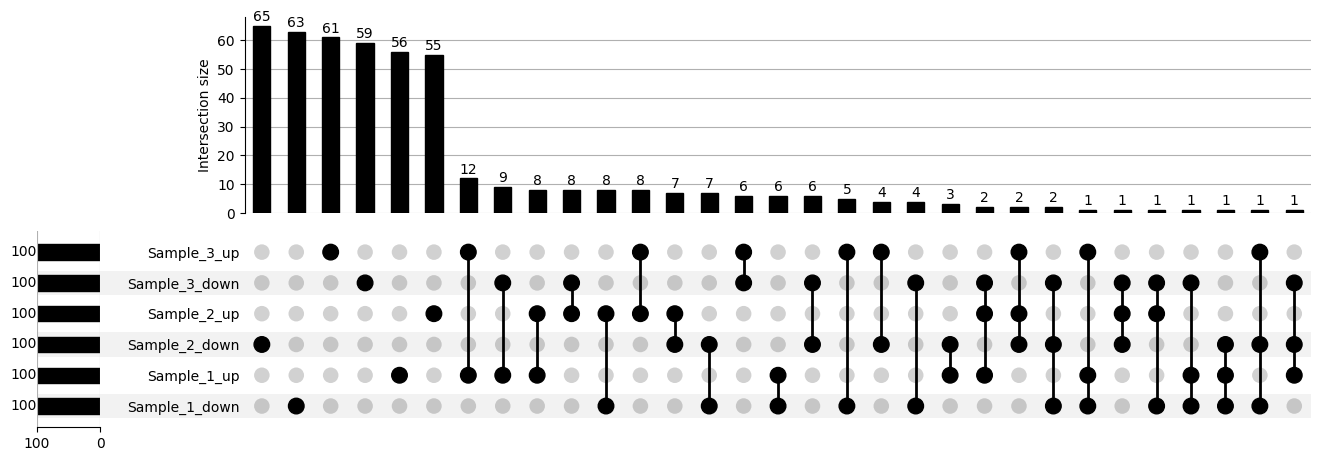

In [16]:
import pandas as pd
import numpy as np
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Simulate Differential Gene Expression Data
# ------------------------------------------------------------

# Set random seed for reproducibility
np.random.seed(42)

# Generate a list of 1000 fake human gene symbols (GENE1, GENE2, ..., GENE1000)
all_genes = [f"GENE{i+1}" for i in range(1000)]

# Define sample names and regulation types
samples = ['Sample_1', 'Sample_2', 'Sample_3']
regulation = ['up', 'down']

# Create a dictionary to store up/down regulated genes for each sample
gene_dict = {}
for sample in samples:
    for reg in regulation:
        # For each sample and regulation, randomly select 100 genes (no replacement)
        gene_dict[f"{sample}_{reg}"] = set(np.random.choice(all_genes, size=100, replace=False))

# ------------------------------------------------------------
# 2. Prepare Data for UpSet Analysis
# ------------------------------------------------------------

# Create a DataFrame where each row is a (gene, set) pair
# This structure allows us to track which gene is present in which up/down set
all_sets = []
for set_name, genes in gene_dict.items():
    for gene in genes:
        all_sets.append({'gene': gene, 'set': set_name})

df = pd.DataFrame(all_sets)

# For each gene, collect all sets (up/down/sample) in which it appears
# Result: Series with index=gene, value=tuple of set names
memberships = df.groupby('gene')['set'].apply(lambda x: tuple(sorted(x)))

# ------------------------------------------------------------
# 3. Build Intersection Table for Export
# ------------------------------------------------------------

# Group by unique set-combinations (intersections)
# For each intersection, collect the genes and count them
intersection_df = (
    memberships
    .reset_index()
    .groupby('set')['gene']
    .agg(['count', lambda x: ';'.join(x)])
    .reset_index()
)
intersection_df.columns = ['sets', 'gene_count', 'genes']

# Convert the tuple of sets to a comma-separated string for readability
intersection_df['sets'] = intersection_df['sets'].apply(lambda x: ','.join(x))

# Save the intersection information to a CSV file
# Each row: intersection (sets), number of genes, gene names
intersection_df.to_csv('upset_membership_genes.csv', index=False)

# ------------------------------------------------------------
# 4. UpSet Plot Visualization
# ------------------------------------------------------------

# For plotting, we need the counts of each intersection
membership_counts = memberships.value_counts()

# Convert the intersection information into the format required by upsetplot
upset_data = from_memberships(membership_counts.index, data=membership_counts.values)

# Create and display the UpSet plot
# sort_by='cardinality' arranges intersections by descending size on the x-axis
UpSet(upset_data, show_counts=True, sort_by='cardinality').plot()
plt.show()

# ------------------------------------------------------------
# 5. Output
# ------------------------------------------------------------
# - 'upset_membership_genes.csv' contains:
#     * sets: intersection (comma-separated up/down/sample combinations)
#     * gene_count: number of genes in that intersection
#     * genes: semicolon-separated gene names in that intersection
# - An UpSet plot visualizing the overlaps between all up/down sets across samples

# ------------------------------------------------------------
# 6. Usage Notes
# ------------------------------------------------------------
# - Replace the simulated gene sets with your own gene lists for real data analysis.
# - The script is modular and can be easily adapted for more samples or different set names.
# - The output CSV is useful for downstream analysis or sharing with collaborators.